# RESNET 50 Latest

Found 4504 images belonging to 2 classes.
Found 1126 images belonging to 2 classes.
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 125s 533ms/step - accuracy: 0.7381 - loss: 0.6397 - val_accuracy: 0.3384 - val_loss: 4.0983
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.8574 - loss: 0.3640 - val_accuracy: 0.6616 - val_loss: 0.8767
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 348ms/step - accuracy: 0.8894 - loss: 0.3052 - val_accuracy: 0.3384 - val_loss: 48.3413
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 350ms/step - accuracy: 0.9124 - loss: 0.2448 - val_accuracy: 0.6181 - val_loss: 0.9556
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 53s 358ms/step - accuracy: 0.9069 - loss: 0.2604 - val_accuracy: 0.7016 - val_loss: 0.6235
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.9172 - loss: 0.2448 - val_accuracy: 0.7194 - val_loss: 1.0141
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 354ms/step - accuracy: 0.9300 - loss: 0.2160 - val_accuracy: 0.8437 - val_loss: 0.53

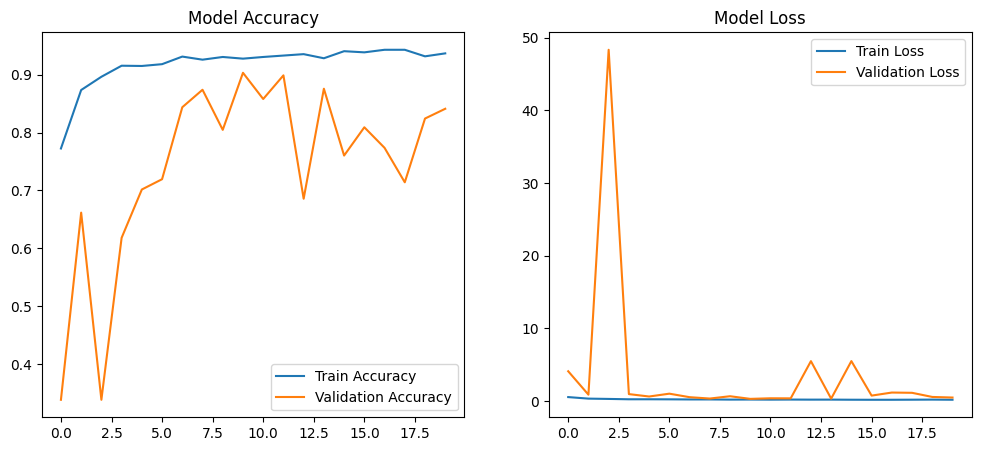

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9127 - loss: 0.2287
Test Accuracy: 0.90


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Input ,BatchNormalization ,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def custom_preprocess_image(image):
    # Convert image to grayscale if it's not already
    if image.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
        image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
    
    # Standardize the image
    image = tf.image.per_image_standardization(image)

    # Perform histogram equalization on the grayscale image
    image = tf.image.adjust_gamma(image, gamma=1.0)  # Simple adjustment as an example
    # Note: More complex histogram equalization can be implemented if needed
    
    # Convert grayscale (1 channel) to 3 channels by duplicating the channel
    image = tf.image.grayscale_to_rgb(image)  # Now shape will be (height, width, 3)

    return image

# Dataset Paths
train_dir = "/kaggle/input/major-project/Train/Train"
test_dir = "/kaggle/input/major-project/Test/Test"

# Data Preprocessing with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=custom_preprocess_image
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0 , preprocessing_function=custom_preprocess_image)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode="binary"
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode="binary", shuffle=False
)

# Build Model Using ResNet50
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

inputs = Input(shape=(224, 224, 3))
x = resnet50_base(inputs)
x = GlobalAveragePooling2D()(x)


x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the Model
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    callbacks=[early_stop]
)

# Plot Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Model Loss")

plt.show()

# Evaluate Model
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the trained model
model.save("resnet50_oil_spill_model.h5")


# Prediction

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
model = tf.keras.models.load_model('/kaggle/input/resnet50model/resnet50_oil_spill_model.h5')

def predict_resnet50(model, image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)
    return "Oil Spill" if pred[0] > 0.5 else "No Oil Spill"

# Example prediction
sample_image = "/kaggle/input/sampleoilspill/Samples/0_0_0_img_qBIhHv0a36ynbvIW_GIB_cls_1.jpg"
print(f"Prediction for sample image: {predict_resnet50(model, sample_image)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction for sample image: Oil Spill


# METRICS


Found 1126 images belonging to 2 classes.
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step


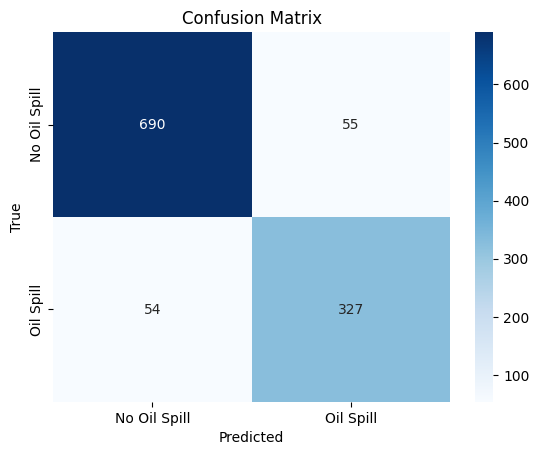

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       745
           1       0.86      0.86      0.86       381

    accuracy                           0.90      1126
   macro avg       0.89      0.89      0.89      1126
weighted avg       0.90      0.90      0.90      1126

Precision: 0.8560
Recall: 0.8583
F1 Score: 0.8571


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Path
test_dir = "/kaggle/input/major-project/Test/Test"

# Data Preprocessing
datagen_test = ImageDataGenerator(rescale=1.0 / 255.0)

test_gen = datagen_test.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode="binary", shuffle=False
)

# Load the trained model
model = tf.keras.models.load_model('/kaggle/input/resnet50model/resnet50_oil_spill_model.h5')

# Predict the results on the test set
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No Oil Spill', 'Oil Spill'], yticklabels=['No Oil Spill', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculating Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
